In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np

WORK_PATH = "./"
SOURCE_PATH = os.path.join(WORK_PATH, "src")
sys.path.append(SOURCE_PATH)

In [3]:
from graphnics import FenicsGraph

/usr/local/lib/python3.11/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [4]:
import tissue, fem, visualize

TEST_GRAPH = FenicsGraph()
TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],
    1: [0.010, 0.020, 0.015],
    2: [0.022, 0.013, 0.015],
    3: [0.022, 0.028, 0.015],
    4: [0.015, 0.005, 0.015],
    5: [0.015, 0.035, 0.015],
    6: [0.038, 0.005, 0.015],
    7: [0.038, 0.035, 0.015]
}
for node_id, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node_id, pos=pos)
TEST_GRAPH_EDGES = [
    (0, 1, 0.004),
    (1, 2, 0.003),
    (1, 3, 0.003),
    (2, 4, 0.002),
    (2, 6, 0.003),
    (3, 5, 0.002),
    (3, 7, 0.003)
]
for (u, v, radius) in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

Omega_bounds = np.array([[0, 0, 0], [0.08, 0.08, 0.08]])
mesh_builder = tissue.MeshBuild(
    TEST_GRAPH,
    Omega_bounds=Omega_bounds,
    Omega_mesh_voxel_dim=(24, 24, 24),
    Lambda_num_nodes_exp=2
)

sink_face = mesh_builder.get_Omega_axis_plane("left")

measure_builder = tissue.DomainBuild(
    mesh_build=mesh_builder,
    Lambda_inlet=[0],
    Omega_sink=sink_face
)

_pos = np.array(TEST_GRAPH.nodes[7]['pos'])
_offset = np.array([0.005, 0.005, 0.005])
_upper_cube_bounds_val = [_pos - _offset, _pos + _offset]

CUBES_TEST = fem.Velo(
    domain = measure_builder,
    gamma = 1.0e-10,
    gamma_R = 10.0,
    gamma_a = 0,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 4.0e-11, # Vessel permeability in 1D
    P_in = 100 * 133.322,
    p_cvp = 1.0 * 133.322
)

Averaging over 28 cells: 100%|██████████| 28/28 [00:00<00:00, 2203.68it/s]


In [5]:
CUBES_TEST.print_diagnostics()

Flow Diagnostic Report:
--------------------------------------------------
Sink Boundary:
  Inflow               : 0
  Outflow              : 2.27073e-09
  Net Flow (sum)       : 2.27073e-09
  Net Flow (Dolfin)    : 2.27073e-09
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Neumann Boundary:
  Net Flow (Dolfin)    : 1.08417e-10
--------------------------------------------------
Entire Domain Boundary:
  Inflow               : -2.03441e-11
  Outflow              : 2.39949e-09
  Net Flow (sum)       : 2.37915e-09
  Net Flow (Dolfin)    : 2.37915e-09
  --> The 'Net Flow (sum)' should equal 'Net Flow (Dolfin)'.
--------------------------------------------------
Sum of dsOmegaNeumann and dsOmegaSink (Dolfin):
  Neumann + Sink       : 2.37915e-09
  --> This should match the net flow over the entire domain boundary.
--------------------------------------------------


In [ ]:
cube_lower_bounds = CUBES_TEST.lower_cube_bounds
cube_upper_bounds = CUBES_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

fig1 = visualize.plot_with_boundaries(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)
fig1.show()

In [4]:
fig1 = visualize.plot_path_pressure(CUBES_TEST.uh1d, TEST_GRAPH, [0, 1, 3, 7])
fig1.show()

NameError: name 'visualize' is not defined

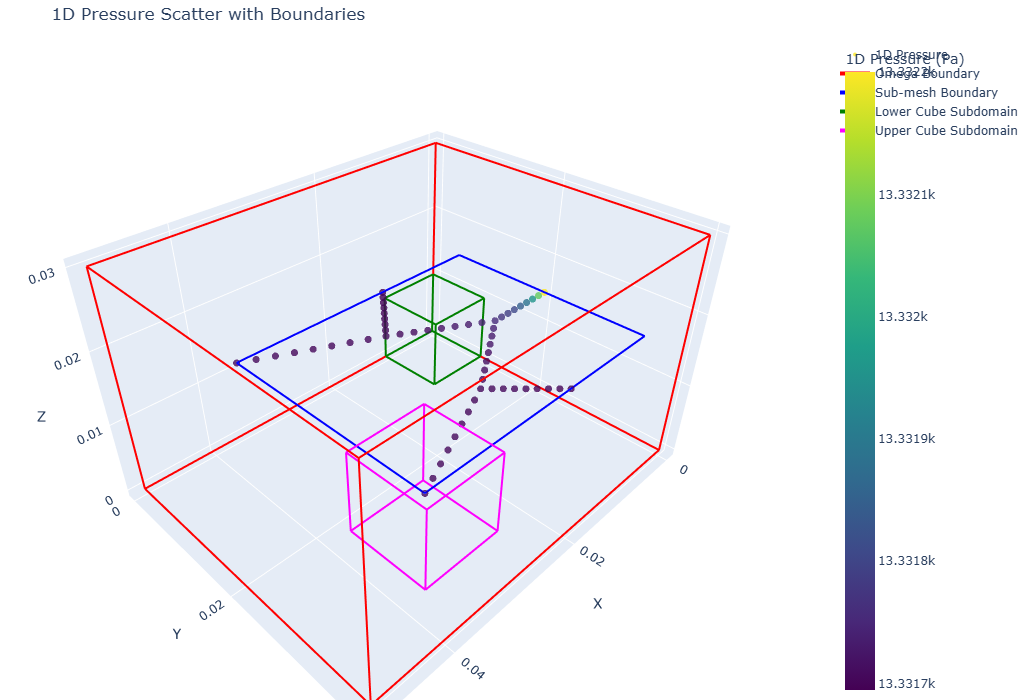

In [26]:
visualize.plot_with_boundaries_plotly(CUBES_TEST.uh1d, CUBES_TEST.uh3d,
     cube_lower=cube_lower_bounds,
     cube_upper=cube_upper_bounds)

In [34]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBES_TEST.save_vtk(SAVE_PATH)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_sweep(param_name, values, defaults):
    fluxes = []
    for val in values:
        params = defaults.copy()
        params[param_name] = val
        cube_test = fem.SubCubes(**params)
        flux = cube_test.compute_upper_cube_flux()
        fluxes.append(flux)
    return fluxes

def vary_parameters_and_plot(num_points=50, subset_plots = ['k_t', 'gamma', 'gamma_R']):
    common_params = {
        'domain': measure_builder,
        'gamma': 1.0,
        'gamma_R': 1.0e-7,
        'gamma_a': 1.0e-10,
        'mu': 1.0e-3,
        'k_t': 1.0e-10,
        'k_v': 1.0e-8,
        'P_in': 100.0 * 133.322,
        'p_cvp': 1.0 * 133.322,
        'lower_cube_bounds': [[0.000,0.000,0.000],[0.01, 0.01, 0.01]],
        'upper_cube_bounds': _upper_cube_bounds_val
    }

    sweep_configs = {
        'k_t': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Tissue Permeability k_t",
            'title': "Upper Cube Flux vs. Tissue Permeability k_t",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma': {
            'values': np.logspace(-10, 2, num_points),
            'xlabel': "Gamma",
            'title': "Upper Cube Flux vs. Gamma",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma_R': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Gamma_R",
            'title': "Upper Cube Flux vs. Gamma_R",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        }
    }

    num_plots = len(subset_plots)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))
    if num_plots == 1:
        axes = [axes]

    for idx, param in enumerate(subset_plots):
        config = sweep_configs[param]
        values = config['values']
        fluxes = run_sweep(param, values, common_params)

        if config['plot_type'] == 'semilogx':
            axes[idx].semilogx(values, fluxes, marker='o', linestyle='-')
        else:
            axes[idx].plot(values, fluxes, marker='o', linestyle='-')

        axes[idx].set_xlabel(config['xlabel'])
        axes[idx].set_ylabel("Upper Cube Flux")
        axes[idx].set_title(config['title'])
        axes[idx].grid(True, **config['grid_kwargs'])

    plt.tight_layout()
    plt.show()

vary_parameters_and_plot(num_points=50)

Averaging over 56 cells: 100%|██████████| 56/56 [00:00<00:00, 2202.21it/s]

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1620.65it/s]


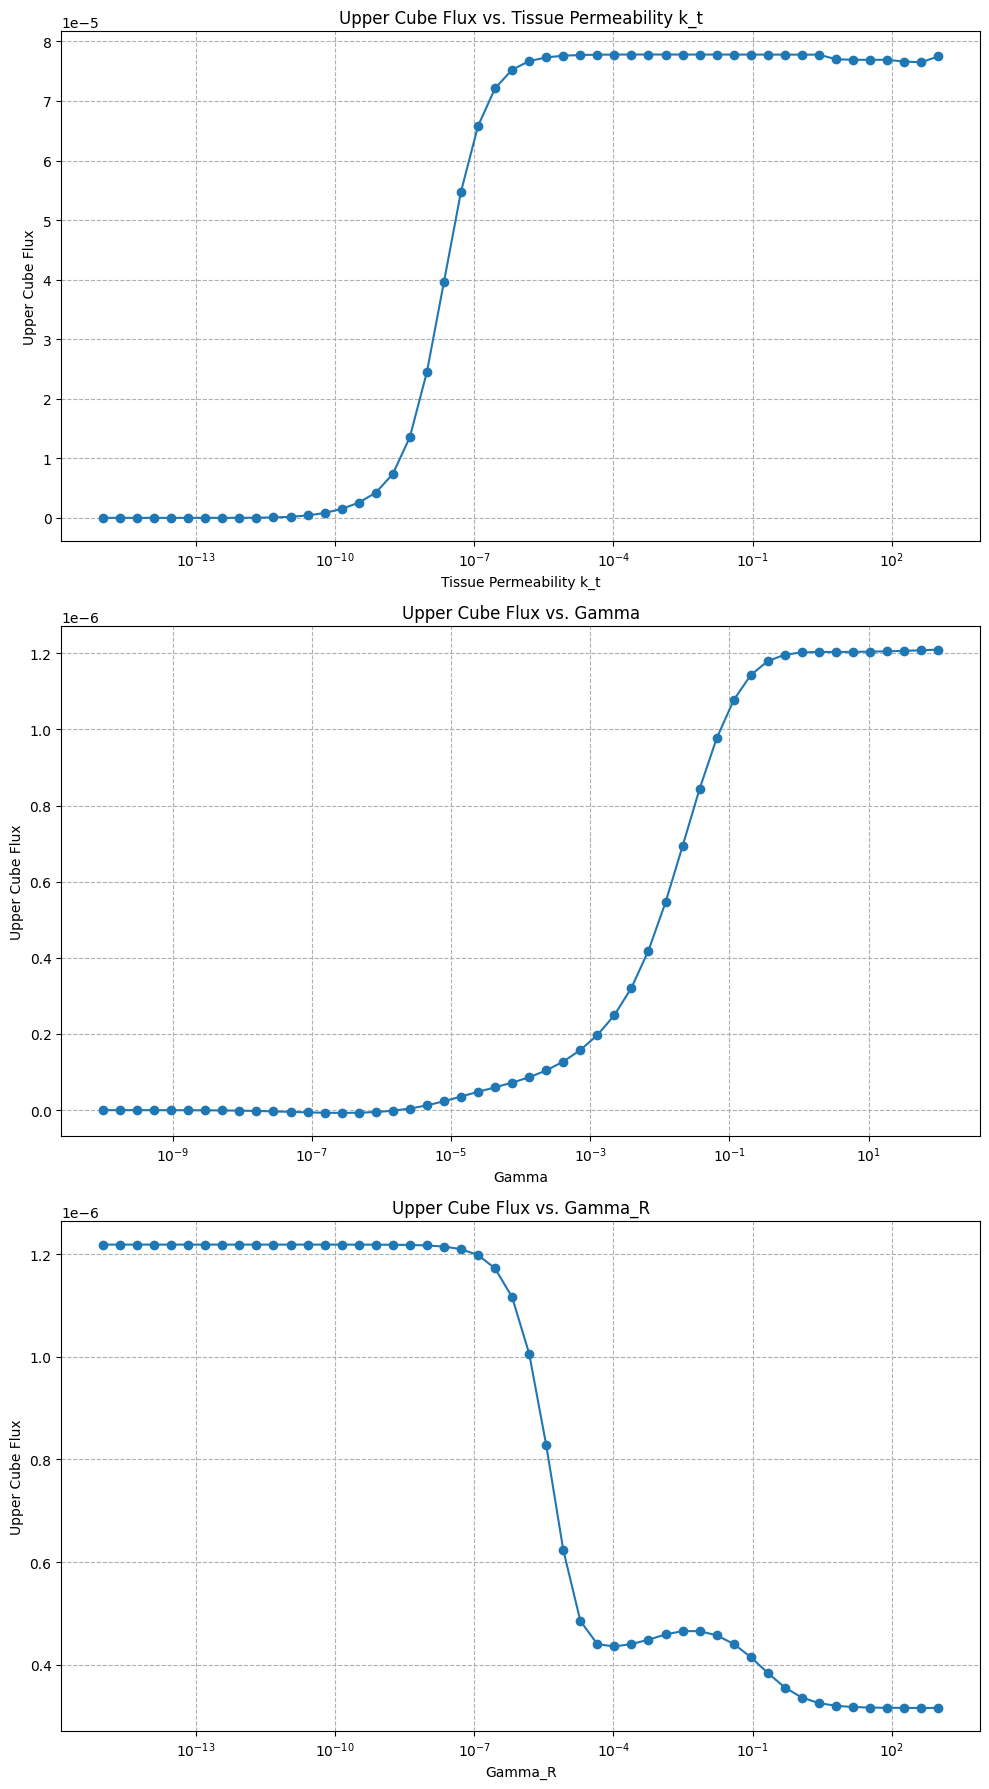

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

def run_sweep_lower(param_name, values, defaults):
    fluxes = []
    for val in values:
        params = defaults.copy()
        params[param_name] = val
        cube_test = fem.SubCubes(**params)
        flux = cube_test.compute_lower_cube_flux()
        fluxes.append(flux)
    return fluxes

def vary_parameters_and_plot_lower(num_points=50, subset_plots = ['k_t', 'gamma', 'gamma_R']):
    common_params = {
        'domain': TEST_MEASURE,
        'gamma': 1.0,
        'gamma_R': 1.0e-7,
        'gamma_a': 1.0e-10,
        'mu': 1.0e-3,
        'k_t': 1.0e-10,
        'k_v': 1.0e-8,
        'P_in': 100.0 * 133.322,
        'p_cvp': 1.0 * 133.322,
        'lower_cube_bounds': [[0.000,0.000,0.000],[0.01, 0.01, 0.01]],
        'upper_cube_bounds': _upper_cube_bounds_val
    }

    sweep_configs = {
        'k_t': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Tissue Permeability k_t",
            'title': "Upper Cube Flux vs. Tissue Permeability k_t",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma': {
            'values': np.logspace(-10, 2, num_points),
            'xlabel': "Gamma",
            'title': "Upper Cube Flux vs. Gamma",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma_R': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Gamma_R",
            'title': "Upper Cube Flux vs. Gamma_R",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        }
    }

    num_plots = len(subset_plots)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))
    if num_plots == 1:
        axes = [axes]

    for idx, param in enumerate(subset_plots):
        config = sweep_configs[param]
        values = config['values']
        fluxes = run_sweep_lower(param, values, common_params)

        if config['plot_type'] == 'semilogx':
            axes[idx].semilogx(values, fluxes, marker='o', linestyle='-')
        else:
            axes[idx].plot(values, fluxes, marker='o', linestyle='-')

        axes[idx].set_xlabel(config['xlabel'])
        axes[idx].set_ylabel("Lower Cube Flux")
        axes[idx].set_title(config['title'])
        axes[idx].grid(True, **config['grid_kwargs'])

    plt.tight_layout()
    plt.show()

vary_parameters_and_plot(num_points=50)